# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')
con = sqlite3.connect('/content/drive/My Drive/Asgn/database.sqlite')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:03<00:00, 1984.21it/s]


In [24]:
preprocessed_reviews[600]

'wow works great follow directions get guys pegged three two weeks yard back make sure tap mole runs know active thanks'

In [0]:
final['cleanedText']=preprocessed_reviews

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [26]:
#Taking random 60000 ponits

final_data = final.sample(n=80000)

final_data.shape

(80000, 11)

In [27]:
# Sorting data based on time
final_data["Time"] = pd.to_datetime(final_data["Time"], unit = "s")
final_df = final_data.sort_values(by = "Time")
print(final.shape)
final_df.head(5)

(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
121041,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,1,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,recently purchased woodstream corp gopher trap...


In [28]:
# 80k data which will use to train model after vectorization
X = final_df['cleanedText']
print("shape of X:", X.shape)
# class label
Y = final_df["Score"]
print("shape of Y:", Y.shape)

shape of X: (80000,)
shape of Y: (80000,)


In [29]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 52)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print(X_train.shape, y_train.shape, x_test.shape)

(56000,) (56000,) (24000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bowt=count_vect.fit_transform(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bowts = count_vect.transform(x_test)
print("the type of count vectorizer ",type(bowts))
print("the shape of out text BOW vectorizer ",bowts.get_shape())
print("the number of unique words ", bowts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaah', 'aaaahhhhhh', 'aaaand', 'aaaannnnddd', 'aaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (24000, 45470)
the number of unique words  45470


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10,)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (56000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer( min_df=10)
tfidft=tf_idf_vect.fit_transform(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidfts = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(tfidft))
print("the shape of out text TFIDF vectorizer ",tfidft.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidft.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abdominal', 'ability', 'able', 'absence', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absorb']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (56000, 9416)
the number of unique words including both unigrams and bigrams  9416


## [4.4] Word2Vec

In [0]:
# Training for Xtrain
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14518
sample words  ['happy', 'price', 'cats', 'love', 'keep', 'hand', 'time', 'even', 'picky', 'eater', 'no', 'problem', 'tried', 'pasta', 'last', 'night', 'wow', 'really', 'good', 'gluten', 'free', 'eight', 'years', 'sooo', 'many', 'brands', 'mild', 'success', 'blows', 'away', 'brand', 'came', 'close', 'considered', 'okay', 'celiac', 'intolerant', 'person', 'knows', 'served', 'right', 'refrigerate', 'reheat', 'bad', 'things', 'come', 'not', 'held', 'like', 'champ']


In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
#print(len(sent_vectors_tr[0]))

100%|██████████| 56000/56000 [02:23<00:00, 391.28it/s]

56000


In [0]:
from sklearn import preprocessing
Xavg=preprocessing.normalize(sent_vectors_tr)

In [38]:
print(Xavg.shape)

(56000, 50)


In [0]:
# Training for Xtest
i=0
list_of_sent_ts=[]
for sent in x_test.values:
   list_of_sent_ts.append(sent.split())

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 24000/24000 [01:01<00:00, 390.07it/s]

24000
50


In [0]:
#Xtsavg=sent_vectors_ts
Xtsavg = preprocessing.normalize(sent_vectors)

In [43]:
print(Xtsavg.shape)

(24000, 50)


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [45]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 56000/56000 [31:22<00:00, 29.75it/s]


In [0]:
from sklearn import preprocessing
xtfidf = preprocessing.normalize(tfidf_sent_vectors)
#print(tfidf_sent_vectors.shape)

In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectorsts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsts.append(sent_vec)
    row += 1

100%|██████████| 24000/24000 [12:30<00:00, 32.00it/s]


In [0]:
xtstfidf = preprocessing.normalize(tfidf_sent_vectorsts)

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

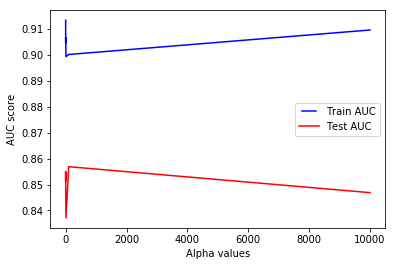

In [81]:

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
a = [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4]
param_grid= {'penalty':['l1','l2']}
train_results = []
test_results = []
for i in a:
  clf = linear_model.SGDClassifier(loss='hinge', n_jobs = -1, class_weight = "balanced",)
  clf.fit(bowt, y_train)          
  model = GridSearchCV(clf, param_grid=param_grid, cv = 5, n_jobs =-1, scoring = 'roc_auc')
  model.fit(bowt, y_train)
  train_pred = model.predict(bowt)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)
  y_pred2 = model.predict(bowts)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(a, train_results, "b", label="Train AUC")
line2, = plt.plot(a, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Alpha values")
plt.show()

In [71]:
#Training with best alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
model = CalibratedClassifierCV(clf ,cv=5, method='sigmoid',)
model.fit(bowt, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

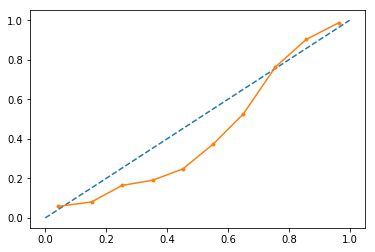

In [72]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs = model.predict_proba(bowts)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

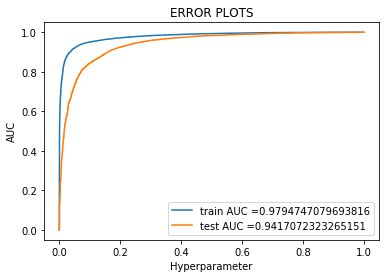

Train confusion matrix
[[ 5175  3653]
 [  487 46685]]
Test confusion matrix
[[ 1972  1835]
 [  359 19834]]


In [73]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(bowt)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(bowts)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(bowt)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(bowts)))

In [74]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, model.predict(bowt))
cm

array([[ 5175,  3653],
       [  487, 46685]])

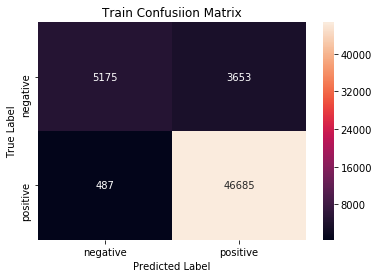

In [75]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [76]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,model.predict(bowts))
cm

array([[ 1972,  1835],
       [  359, 19834]])

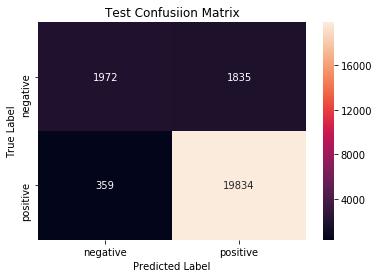

In [77]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
#Top features for both classes
#https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 a=top_positive_coefficients
 b=top_negative_coefficients
 # create plot
 plt.figure(figsize=(25, 5))
 colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60)
 plt.show()

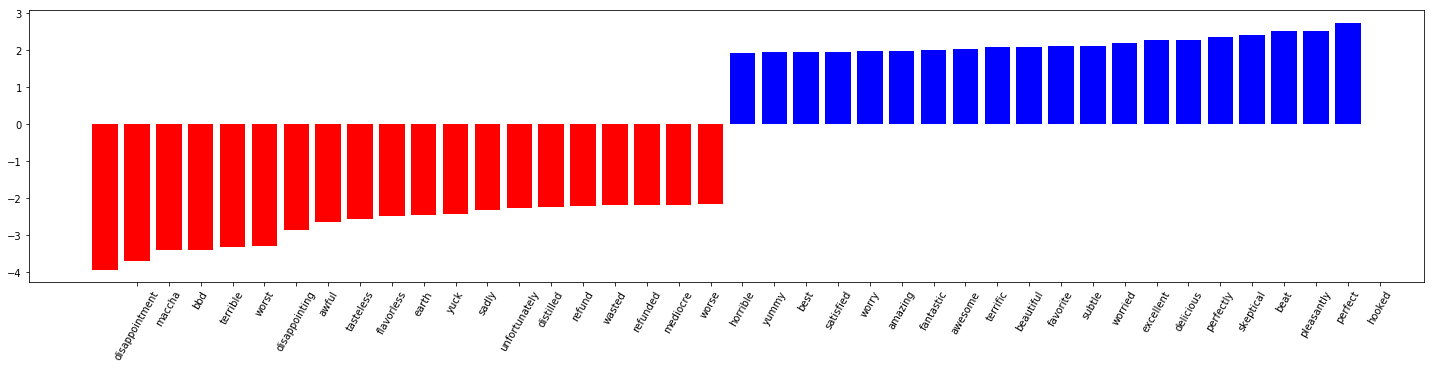

In [79]:
plot_coefficients(clf, count_vect.get_feature_names())

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

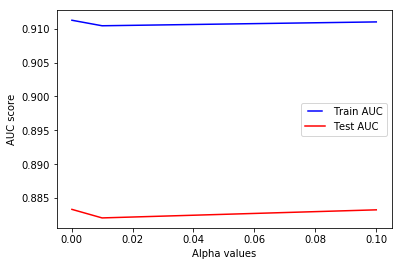

In [87]:

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
a = [10**-4, 10**-2, 10**-1, ]
param_grid= {'penalty':['l1','l2']}
train_results1 = []
test_results1 = []
for i in a:
  clf1 = linear_model.SGDClassifier(loss='hinge', n_jobs = -1, class_weight = "balanced",)
  clf1.fit(tfidft, y_train)          
  model = GridSearchCV(clf1, param_grid=param_grid, cv = 5, n_jobs =-1, scoring = 'roc_auc')
  model.fit(tfidft, y_train)
  train_pred = model.predict(tfidft)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results1.append(roc_auc)
  y_pred2 = model.predict(tfidfts)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results1.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(a, train_results1, "b", label="Train AUC")
line2, = plt.plot(a, test_results1, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Alpha values")
plt.show()

In [88]:
#Training with best alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
model1 = CalibratedClassifierCV(clf1 ,cv=5, method='sigmoid',)
model1.fit(tfidft, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

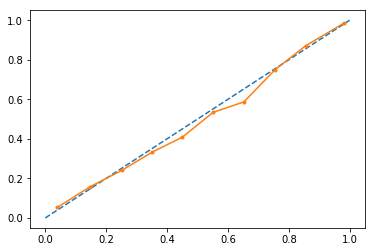

In [89]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs = model1.predict_proba(tfidfts)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

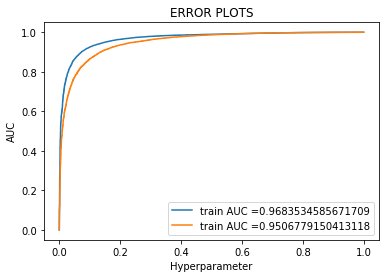

Train confusion matrix
[[ 6654  2174]
 [ 1283 45889]]
Test confusion matrix
[[ 2523  1284]
 [  625 19568]]


In [90]:
train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train, model1.predict_proba(tfidft)[:,1])
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(tfidfts)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="train AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model1.predict(tfidft)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model1.predict(tfidfts)))

In [91]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_train,model1.predict(tfidft))
cm1

array([[ 6654,  2174],
       [ 1283, 45889]])

In [92]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_train,model1.predict(tfidft))
cm1

array([[ 6654,  2174],
       [ 1283, 45889]])

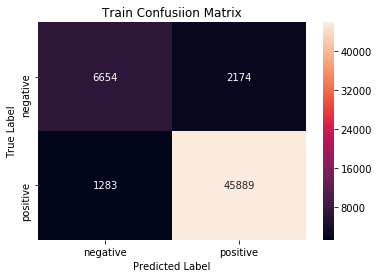

In [93]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [94]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test,model1.predict(tfidfts))
cm1

array([[ 2523,  1284],
       [  625, 19568]])

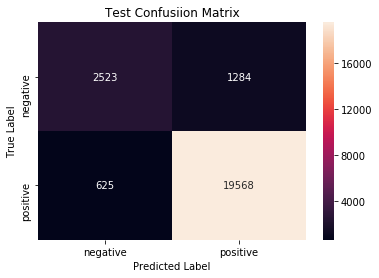

In [95]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
#Top features for both classes
def plot_coefficients1(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 a=top_positive_coefficients
 b=top_negative_coefficients
 # create plot
 plt.figure(figsize=(30, 5))
 colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60)
 plt.show()

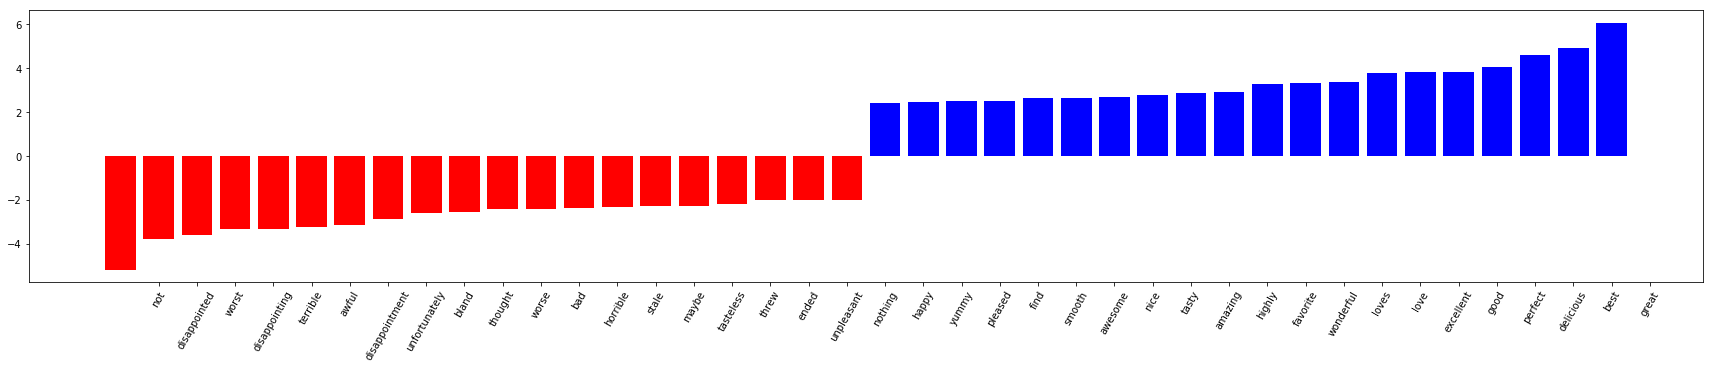

In [97]:
plot_coefficients1(clf1, tf_idf_vect.get_feature_names())

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

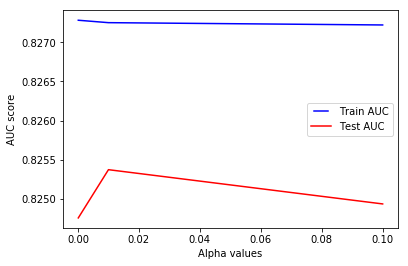

In [99]:

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
a = [10**-4, 10**-2, 10**-1, ]
param_grid= {'penalty':['l1','l2']}
train_results2 = []
test_results2 = []
for i in a:
  clf2 = linear_model.SGDClassifier(loss='hinge', n_jobs = -1, class_weight = "balanced",)
  clf2.fit(Xavg, y_train)          
  model = GridSearchCV(clf2, param_grid=param_grid, cv = 5, n_jobs =-1, scoring = 'roc_auc')
  model.fit(Xavg, y_train)
  train_pred = model.predict(Xavg)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results2.append(roc_auc)
  y_pred2 = model.predict(Xtsavg)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results2.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(a, train_results2, "b", label="Train AUC")
line2, = plt.plot(a, test_results2, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Alpha values")
plt.show()

In [100]:
#Training with best hyperparameter
model2 = CalibratedClassifierCV(clf2 ,cv=5, method='sigmoid',)
model2.fit(Xavg, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

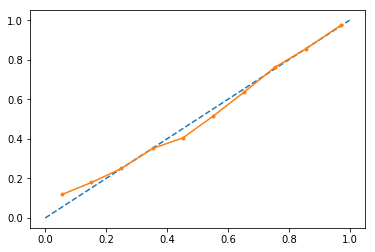

In [101]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs2 = model2.predict_proba(Xtsavg)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs2, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

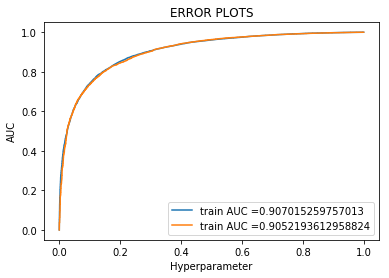

Train confusion matrix
[[ 4221  4607]
 [ 1667 45505]]
Test confusion matrix
[[ 1845  1962]
 [  701 19492]]


In [102]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model2.predict_proba(Xavg)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model2.predict_proba(Xtsavg)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model2.predict(Xavg)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model2.predict(Xtsavg)))

In [103]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train,model2.predict(Xavg))
cm2

array([[ 4221,  4607],
       [ 1667, 45505]])

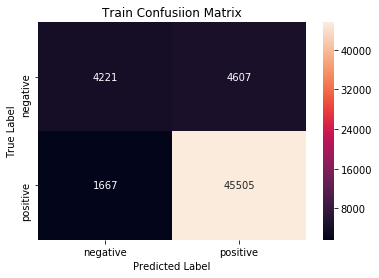

In [104]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [105]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test,model2.predict(Xtsavg))
cm2

array([[ 1845,  1962],
       [  701, 19492]])

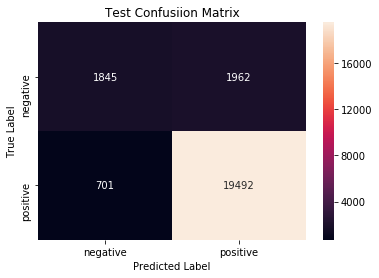

In [106]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

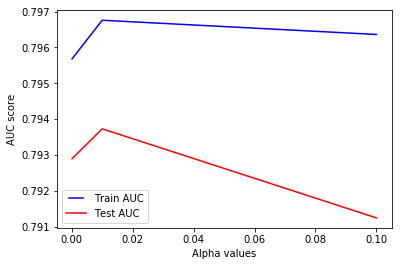

In [107]:

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
a = [10**-4, 10**-2, 10**-1, ]
param_grid= {'penalty':['l1','l2']}
train_results3 = []
test_results3 = []
for i in a:
  clf3 = linear_model.SGDClassifier(loss='hinge', n_jobs = -1, class_weight = "balanced",)
  clf3.fit(xtfidf, y_train)          
  model3 = GridSearchCV(clf3, param_grid=param_grid, cv = 5, n_jobs =-1, scoring = 'roc_auc')
  model3.fit(xtfidf, y_train)
  train_pred = model3.predict(xtfidf)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results3.append(roc_auc)
  y_pred2 = model3.predict(xtstfidf)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results3.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(a, train_results3, "b", label="Train AUC")
line2, = plt.plot(a, test_results3, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Alpha values")
plt.show()

In [108]:
#Training with best hyperparameter
model3 = CalibratedClassifierCV(clf3 ,cv=5, method='sigmoid',)
model3.fit(xtfidf, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

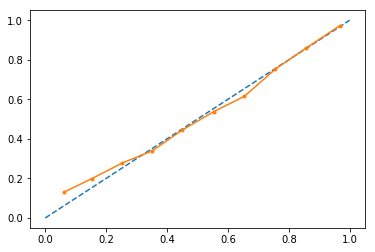

In [109]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs2 = model3.predict_proba(xtstfidf)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs2, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

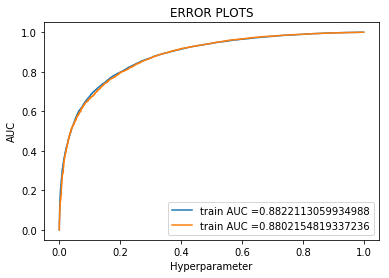

Train confusion matrix
[[ 3408  5420]
 [ 1567 45605]]
Test confusion matrix
[[ 1502  2305]
 [  663 19530]]


In [110]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, model3.predict_proba(xtfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model3.predict_proba(xtstfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model3.predict(xtfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model3.predict(xtstfidf)))

In [111]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_train,model3.predict(xtfidf))
cm3

array([[ 3408,  5420],
       [ 1567, 45605]])

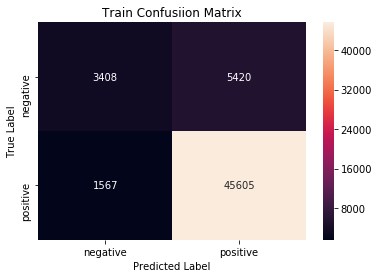

In [112]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [113]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test,model3.predict(xtstfidf))
cm3

array([[ 1502,  2305],
       [  663, 19530]])

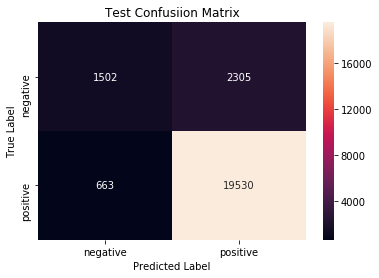

In [114]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [5.2] RBF SVM

In [116]:
#Taking random 60000 ponits

final_data1 = final.sample(n=20000)

final_data1.shape

(20000, 11)

In [117]:
# Sorting data based on time
final_data1["Time"] = pd.to_datetime(final_data1["Time"], unit = "s")
final_df1 = final_data1.sort_values(by = "Time")
print(final_df1.shape)

(20000, 11)


In [118]:
# 80k data which will use to train model after vectorization
X1 = final_df1['cleanedText']
print("shape of X:", X1.shape)
# class label
Y1 = final_df1["Score"]
print("shape of Y:", Y1.shape)

shape of X: (20000,)
shape of Y: (20000,)


In [119]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size = 0.3, random_state = 52)
X_traincv1, X_cv1, y_traincv1, y_cv1 = train_test_split(X_train1, y_train1, test_size=0.33)
print(X_train1.shape, y_train1.shape, x_test1.shape)
print(X_traincv1.shape, y_traincv1.shape, y_cv1.shape)

(14000,) (14000,) (6000,)
(9380,) (9380,) (4620,)


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [120]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bowr=count_vect.fit_transform(X_train1)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bowtr = count_vect.transform(x_test1)
print("the type of count vectorizer ",type(bowtr))
print("the shape of out text BOW vectorizer ",bowtr.get_shape())
print("the number of unique words ", bowtr.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaaa', 'aaaaaand', 'aaaahhhhhh', 'aaah', 'aaahs', 'aafco', 'aahs', 'aamazon']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 23817)
the number of unique words  23817


In [0]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

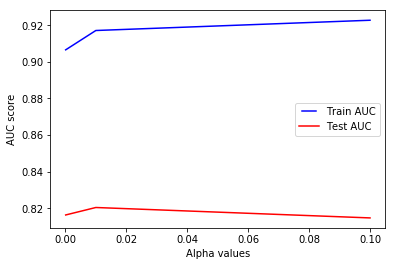

In [122]:

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
c = [10**-4, 10**-2, 10**-1, 10**0,]
param_grid= {'penalty':['l1','l2']}
train_results = []
test_results = []
for i in a:
  svm = SVC(kernel='rbf', gamma="auto_deprecated",random_state=0,class_weight = "balanced",)
  svm.fit(bowr, y_train1)          
  model4 = GridSearchCV(clf, param_grid=param_grid, cv = 5, n_jobs =-1, scoring = 'roc_auc')
  model4.fit(bowr, y_train1)
  train_pred = model4.predict(bowr)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train1, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)
  y_pred2 = model4.predict(bowtr)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred2)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(a, train_results, "b", label="Train AUC")
line2, = plt.plot(a, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("C values")
plt.show()

In [123]:
#https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

from sklearn.calibration import CalibratedClassifierCV
model4 = CalibratedClassifierCV(svm , cv=5, method='sigmoid')
model4.fit(bowr, y_train1)

CalibratedClassifierCV(base_estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
            cv=5, method='sigmoid')

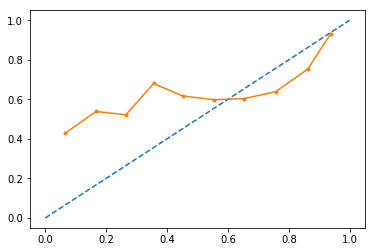

In [124]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs2 = model4.predict_proba(bowtr)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test1, probs2, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

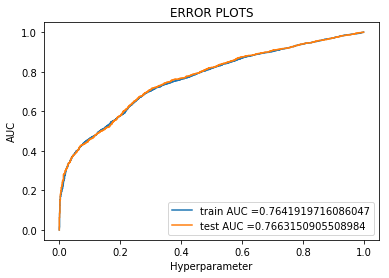

In [126]:

train_fpr, train_tpr, thresholds = roc_curve(y_train1, model4.predict_proba(bowr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test1, model4.predict_proba(bowtr)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



In [127]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(y_train1, model4.predict(bowr))
cm4

array([[  149,  2115],
       [  190, 11546]])

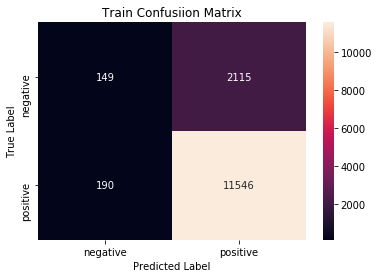

In [128]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm4, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [129]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(y_test1, model4.predict(bowtr))
cm4

array([[  55,  907],
       [  75, 4963]])

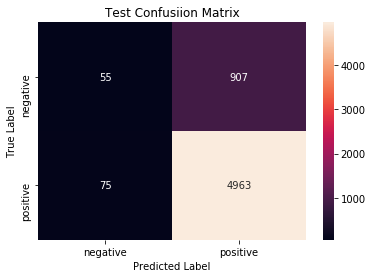

In [130]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm4, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [131]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidftr=tf_idf_vect.fit_transform(X_train1)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidftsr = tf_idf_vect.transform(x_test1)
print("the type of count vectorizer ",type(tfidftr))
print("the shape of out text TFIDF vectorizer ",tfidftr.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidftr.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able enjoy', 'able find', 'able get', 'able order', 'able purchase', 'able use']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (14000, 8458)
the number of unique words including both unigrams and bigrams  8458


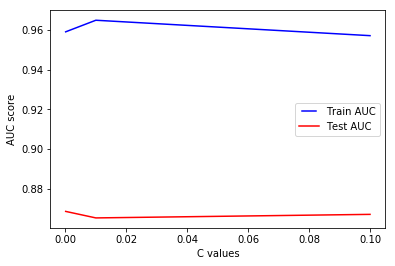

In [133]:

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
c = [10**-4, 10**-2, 10**-1, 10**0,]
param_grid= {'penalty':['l1','l2']}
train_results5 = []
test_results5 = []
for i in a:
  svm = SVC(kernel='rbf', gamma="auto_deprecated",random_state=0,class_weight = "balanced",)
  svm.fit(tfidftr, y_train1)          
  model5 = GridSearchCV(clf, param_grid=param_grid, cv = 5, n_jobs =-1, scoring = 'roc_auc')
  model5.fit(tfidftr, y_train1)
  train_pred = model5.predict(tfidftr)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train1, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results5.append(roc_auc)
  y_pred2 = model5.predict(tfidftsr)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred2)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results5.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(a, train_results5, "b", label="Train AUC")
line2, = plt.plot(a, test_results5, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("C values")
plt.show()

In [134]:
#https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

from sklearn.calibration import CalibratedClassifierCV
model5 = CalibratedClassifierCV(svm , cv=5, method='sigmoid')
model5.fit(tfidftr, y_train1)


CalibratedClassifierCV(base_estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
            cv=5, method='sigmoid')

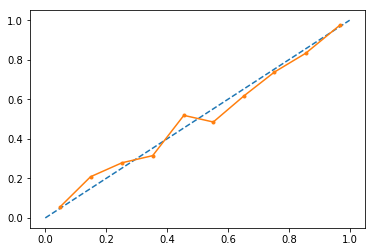

In [135]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs2 = model5.predict_proba(tfidftsr)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test1, probs2, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

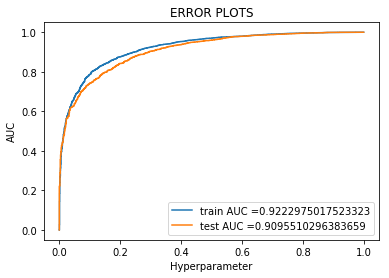

In [136]:
train_fpr, train_tpr, thresholds = roc_curve(y_train1, model5.predict_proba(tfidftr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test1, model5.predict_proba(tfidftsr)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [137]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm5 = confusion_matrix(y_test1,model5.predict(tfidftsr))
cm5

array([[ 458,  504],
       [ 176, 4862]])

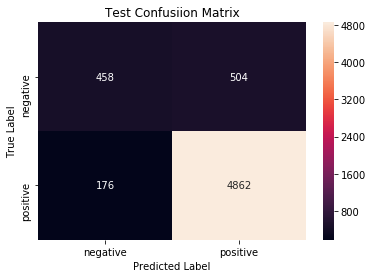

In [138]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm5, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [139]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm5= confusion_matrix(y_train1, model5.predict(tfidftr))
cm5

array([[ 1194,  1070],
       [  398, 11338]])

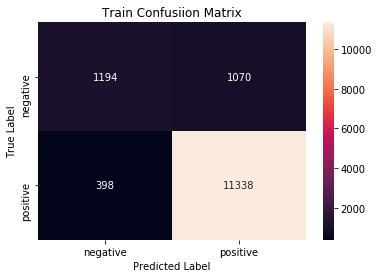

In [140]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm5, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# Training for Xtrain
i=0
list_of_sent=[]
for sent in X_train1.values:
    list_of_sent.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [151]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7317
sample words  ['got', 'gift', 'shop', 'loved', 'much', 'years', 'thought', 'tried', 'brands', 'none', 'good', 'found', 'amazon', 'com', 'extremely', 'pleased', 'ordered', 'delicious', 'sweet', 'pancake', 'syrup', 'green', 'label', 'standard', 'sunday', 'morning', 'breakfasts', 'one', 'store', 'website', 'not', 'even', 'offer', 'sale', 'shame', 'thanks', 'keeping', 'tradition', 'alive', 'well', 'minds', 'us', 'still', 'six', 'member', 'really', 'liked', 'way', 'company', 'took']


In [152]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
#print(len(sent_vectors_tr[0]))

100%|██████████| 14000/14000 [00:16<00:00, 827.31it/s]

14000


In [0]:
from sklearn import preprocessing
Xavg=preprocessing.normalize(sent_vectors_tr)

In [0]:
# Training for Xtest
i=0
list_of_sent_ts=[]
for sent in x_test1.values:
   list_of_sent_ts.append(sent.split())

In [155]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(len(sent_vectors_tr[0]))

100%|██████████| 6000/6000 [00:07<00:00, 839.73it/s]

6000


In [0]:
#Xtsavg=sent_vectors_ts
Xtsavg = preprocessing.normalize(sent_vectors)

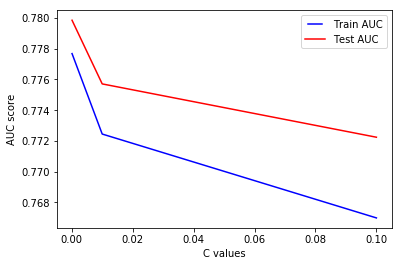

In [159]:

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
c = [10**-4, 10**-2, 10**-1, 10**0,]
param_grid= {'penalty':['l1','l2']}
train_results6 = []
test_results6 = []
for i in a:
  svm = SVC(kernel='rbf', gamma="auto_deprecated",random_state=0,class_weight = "balanced",)
  svm.fit(Xavg, y_train1)          
  model6 = GridSearchCV(clf, param_grid=param_grid, cv = 5, n_jobs =-1, scoring = 'roc_auc')
  model6.fit(Xavg, y_train1)
  train_pred = model6.predict(Xavg)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train1, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results6.append(roc_auc)
  y_pred2 = model6.predict(Xtsavg)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred2)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results6.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(a, train_results6, "b", label="Train AUC")
line2, = plt.plot(a, test_results6, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("C values")
plt.show()

In [160]:
#https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/
# Create a SVC classifier using an RBF kernel
# Train the classifier
model6 = CalibratedClassifierCV(svm , cv=5, method='sigmoid')
model6.fit(Xavg, y_train1)


CalibratedClassifierCV(base_estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
            cv=5, method='sigmoid')

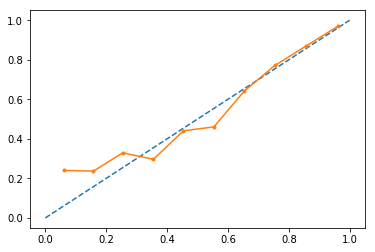

In [161]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs2 = model6.predict_proba(Xtsavg)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test1, probs2, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

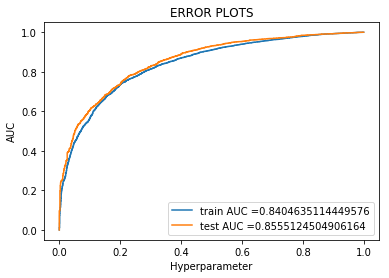

In [162]:
train_fpr, train_tpr, thresholds = roc_curve(y_train1, model6.predict_proba(Xavg)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test1, model6.predict_proba(Xtsavg)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [163]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm6 = confusion_matrix(y_test1,model6.predict(Xtsavg))
cm6

array([[ 260,  702],
       [ 141, 4897]])

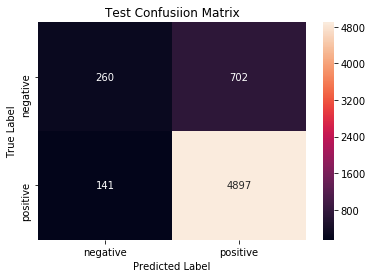

In [164]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm6, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [165]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm6= confusion_matrix(y_train1, model6.predict(Xavg))
cm6

array([[  582,  1682],
       [  360, 11376]])

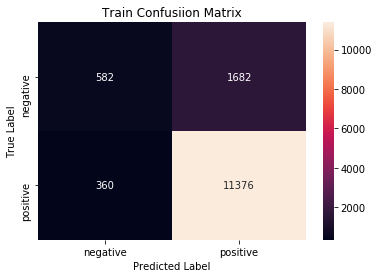

In [166]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm6, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train1)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [168]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 14000/14000 [02:48<00:00, 82.99it/s]


In [0]:
from sklearn import preprocessing
xtfidf1 = preprocessing.normalize(tfidf_sent_vectors)
#print(tfidf_sent_vectors.shape)

In [170]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectorsts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsts.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [01:48<00:00, 55.31it/s]


In [0]:
xtstfidf1 = preprocessing.normalize(tfidf_sent_vectorsts)

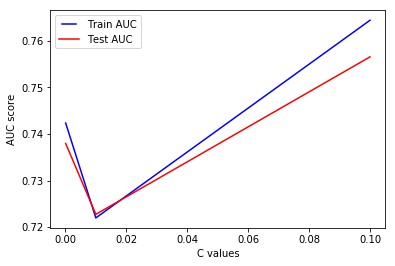

In [172]:

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
c = [10**-4, 10**-2, 10**-1, 10**0,]
param_grid= {'penalty':['l1','l2']}
train_results7 = []
test_results7 = []
for i in a:
  svm = SVC(kernel='rbf', gamma="auto_deprecated",random_state=0,class_weight = "balanced",)
  svm.fit(xtfidf1, y_train1)          
  model7 = GridSearchCV(clf, param_grid=param_grid, cv = 5, n_jobs =-1, scoring = 'roc_auc')
  model7.fit(xtfidf1, y_train1)
  train_pred = model7.predict(xtfidf1)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train1, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results7.append(roc_auc)
  y_pred2 = model7.predict(xtstfidf1)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred2)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results7.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(a, train_results7, "b", label="Train AUC")
line2, = plt.plot(a, test_results7, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("C values")
plt.show()

In [173]:
#https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

from sklearn.calibration import CalibratedClassifierCV
# Train the classifier
svm.fit(xtfidf1, y_train1)
model7 = CalibratedClassifierCV(svm , cv=5, method='sigmoid')
model7.fit(xtfidf1, y_train1)


CalibratedClassifierCV(base_estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
            cv=5, method='sigmoid')

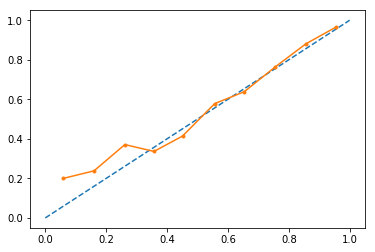

In [174]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs5 = model7.predict_proba(xtstfidf1)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test1, probs5, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

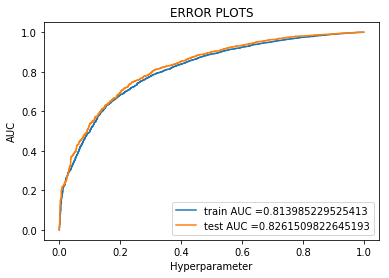

In [175]:
train_fpr, train_tpr, thresholds = roc_curve(y_train1, model7.predict_proba(xtfidf1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test1, model7.predict_proba(xtstfidf1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [176]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm7 = confusion_matrix(y_test1,model7.predict(xtstfidf1))
cm7

array([[ 215,  747],
       [ 107, 4931]])

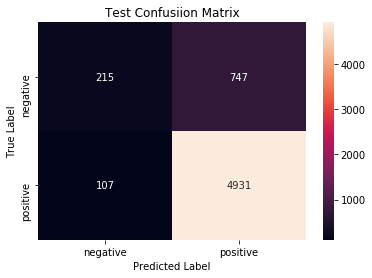

In [177]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm7, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [178]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm7= confusion_matrix(y_test1, model7.predict(xtstfidf1))
cm7

array([[ 215,  747],
       [ 107, 4931]])

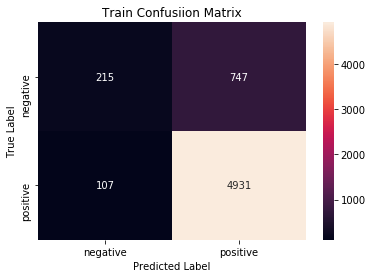

In [179]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm7, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [0]:
#pretty table

from prettytable import PrettyTable
    
p = PrettyTable()

p.field_names = ["Vectoriser model","Kernel", "AUC", ]

p.add_row(["BOW","Linear",  0.94] )
p.add_row(["TFIDF", "Linear", 0.95] )
p.add_row(["AVG W2V","Linear",0.90,] )
p.add_row(["TFIDF W2V","Linear",  0.88,] )
print(p)

r = PrettyTable()
r.field_names = ["Vectoriser model","Kernel", "AUC", ]
r.add_row(["BOW","RBF",  0.76,] )
r.add_row(["TFIDF", "RBF", 0.90] )
r.add_row(["AVG W2V","RBF",  0.85] )
r.add_row(["TFIDF W2V","RBF", 0.82,] )

print(r)

+------------------+--------+------+
| Vectoriser model | Kernel | AUC  |
+------------------+--------+------+
|       BOW        | Linear | 0.93 |
|      TFIDF       | Linear | 0.94 |
|     AVG W2V      | Linear | 0.9  |
|    TFIDF W2V     | Linear | 0.88 |
+------------------+--------+------+
+------------------+--------+------+
| Vectoriser model | Kernel | AUC  |
+------------------+--------+------+
|       BOW        |  RBF   | 0.76 |
|      TFIDF       |  RBF   | 0.91 |
|     AVG W2V      |  RBF   | 0.84 |
|    TFIDF W2V     |  RBF   | 0.83 |
+------------------+--------+------+


**Observations:**

* Applied Linear and RBF kernel for the dataset.
*  Reduced dataset size for RBF as its comptationally expensive. 
*  Plotted AUC curve for train and cv data.
*   Top features are printed.
*  Alpha range is used for finding alpha fit
*   Calibration curve is implemented.
*   Output is improved as gamma is auto tuned.
*   TFIDF has given good AUC score with linear kernel and rbf .
*  Confusion matrices are printed. 
